[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omar2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omar2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


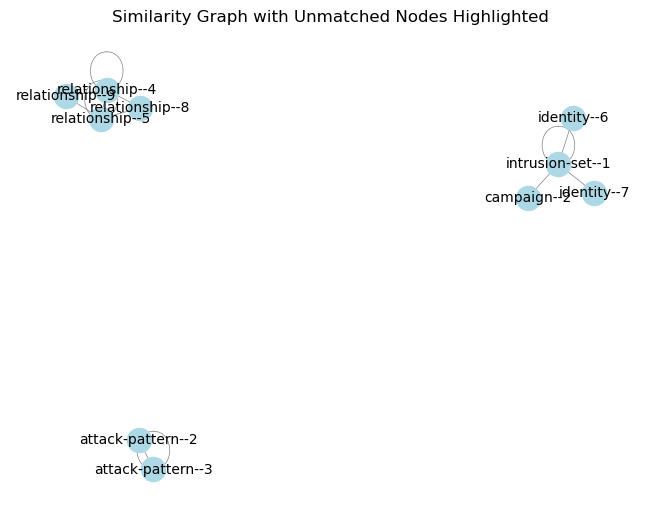

Unmatched Nodes:


In [2]:
import json
import nltk
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

# Load the spaCy NLP model
nlp = spacy.load('en_core_web_sm')

# Ensure resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as file:
        return json.load(file)

def json_to_text(data):
    texts = []
    ids = []
    json_objects = {}
    for entry in data:
        text = ". ".join(f"{key}: {value}" if not isinstance(value, list) else f"{key}: " + ", ".join(map(str, value)) for key, value in entry.items())
        texts.append(text)
        ids.append(entry['id'])
        json_objects[entry['id']] = entry
    return texts, ids, json_objects

def main():
    path1 = input("Enter the file path for JSON 1: ")
    path2 = input("Enter the file path for JSON 2: ")
    
    data1 = load_json(path1)
    data2 = load_json(path2)

    texts1, ids1, json_objects1 = json_to_text(data1)
    texts2, ids2, json_objects2 = json_to_text(data2)

    vectorizer = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords.words('english'))
    tfidf1 = vectorizer.fit_transform(texts1)
    tfidf2 = vectorizer.transform(texts2)

    similarity_matrix = cosine_similarity(tfidf1, tfidf2)

    # Create a graph from the results
    G = nx.Graph()
    threshold = 0.5

    # Add nodes and edges based on similarity
    for i, row in enumerate(similarity_matrix):
        for j, similarity in enumerate(row):
            if similarity > threshold:
                G.add_node(ids1[i], label=json_objects1[ids1[i]]['type'])
                G.add_node(ids2[j], label=json_objects2[ids2[j]]['type'])
                G.add_edge(ids1[i], ids2[j], weight=similarity)

    # Identify and note unmatched nodes
    unmatched_nodes = []
    for id1 in ids1:
        if not any(similarity_matrix[i][j] > threshold for j in range(len(ids2))):
            unmatched_nodes.append(id1)
            G.add_node(id1, label=json_objects1[id1]['type'])
    for id2 in ids2:
        if not any(similarity_matrix[i][j] > threshold for i in range(len(ids1))):
            unmatched_nodes.append(id2)
            G.add_node(id2, label=json_objects2[id2]['type'])

    # Graph visualization
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', width=0.5, font_size=10)
    plt.title('Similarity Graph with Unmatched Nodes Highlighted')
    plt.show()

    # Print unmatched nodes
    print("Unmatched Nodes:")
    for node in unmatched_nodes:
        print(f"{node}: {G.nodes[node]['label']}")

if __name__ == "__main__":
    main()
